In [71]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
import json
import requests

from utility import *

pd.set_option('max_rows', None)

**Get title data (MAKE SURE SPREADSHEET END IS CORRECT WHEN ADDING NEW VOTERS)**

In [72]:
# Authenticate
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
service = build('sheets', 'v4', credentials=gsheet_api_check(SCOPES))

# Pull titles data
start = 'R' # start column of voters
end = 'CM476' # end column, end row of voters
SPREADSHEET_ID = '1Rx-jnDhhyaXdUDr37EVM0yuOLOOhBw1cFj5asIfSlfg'
RANGE_NAME = 'Data!A1:'+chr(ord(start)-2)+end[2:]

data = pull_sheet_data(SCOPES,SPREADSHEET_ID,RANGE_NAME)

COMPLETE: Data copied


In [73]:
# Convert list of lists into numpy array
x = np.array(data)
length = max(map(len, data))
y = np.array([xi+[None]*(length-len(xi)) for xi in x])
#y=np.array([xi for xi in x])
titlesdf = y[1:-1,0]

df = pd.DataFrame(y[1:-1,1:], columns=y[0,1:], index=titlesdf)
df.head(5)

,Rank,Votes,Score,Esoteric Rank,Esoteric Score,Source,Episodes,Studio,First Air Date,Last Air Date,Genres,AniListID,TMDbID,IMGID,AltTitle
18if,437,0,0.0,437,0.0,Manga,13,feel.,2017-07-07,2017-09-29,"Comedy, Slice of Life",21472,72737,/gvKKFv5aIYSAyRY0lCmcYvHqIsN.jpg,None
3000 Leagues in Search of Mother,207,1,32.0,286,2.8,Other,52,Nippon Animation,1976-01-04,1976-12-26,"Adventure, Drama",1663,8962,/cNyYHaHxOytT7DFbVhRrHpkqlst.jpg,None
7 Seeds,285,1,19.0,384,1.0,Manga,24,GONZO,2019-06-28,2020-03-26,"Action, Adventure, Drama, Horror, Mystery, Psy...",105807,85940,/iQMkaPbDKwThXTnpVUAWhtgnQVp.jpg,None
A Certain Scientific Railgun,316,1,14.0,334,1.4,Manga,73,J.C. Staff,2009-10-02,2020-09-25,"Action, Fantasy, Sci-Fi",6213,30977,/dZt1dqw0K4JGhwcqTh8yExHYK9w.jpg,None
A Dog of Flanders,161,1,44.0,63,44.0,Other,52,Nippon Animation,1975-01-05,1975-12-28,"Drama, Slice of Life",2553,45657,/eOjlFXiumBlrn1t8hBu4m6LUS0G.jpg,None


**Get individual votes**

In [74]:
RANGE_NAME = 'Data!'+start+'1:'+end
vote_data = pull_sheet_data(SCOPES,SPREADSHEET_ID,RANGE_NAME)

COMPLETE: Data copied


In [75]:
# Convert list of lists into numpy array
vx = np.array(vote_data)
length = max(map(len, vote_data))
vy = np.array([xi+[None]*(length-len(xi)) for xi in vx])

# This will fail if sheet sorted with 0 vote entries at the bottom
vdf = pd.DataFrame(vy[1:-1,:],columns=vy[0,:],index=titlesdf)

# Make sparse matrix
vdf = vdf.fillna('')
vdf = vdf.replace('',np.nan)
vdf = vdf.astype(pd.SparseDtype("int", np.nan))
print('Density:', vdf.sparse.density)
vdf.head(2)

Density: 0.04977762572699282


,acchonburike,apdoesta,Araby_,baanp,Bagman,BananaSam,bluedelirium,CaptainBoomerang,Chapnik,chumlum,...,tbchico8,TheGendoPose,ThelMi,Toadfan64,trimonuter,Triturate,WeirderisBetter,xo_lauren,YasashiiDia,yellsicklecell
18if,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000 Leagues in Search of Mother,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Make df with voter meta data**

In [76]:
# Number of ranked votes
ranked_votes = [max(max(vdf[vdf[col].notna()][col]),0) for col in vdf.columns]

# Number of unranked votes
unranked_votes = [vdf[vdf[col]==-1][col].count() for col in vdf.columns]

# Total votes
from operator import add
total_votes= list(map(add, ranked_votes, unranked_votes))

vm_index = ['ranked_votes','unranked_votes', 'total_votes']
vm_data = [ranked_votes, unranked_votes, total_votes]

vmdf = pd.DataFrame(vm_data,columns=vy[0,:],index=vm_index)
vmdf

,acchonburike,apdoesta,Araby_,baanp,Bagman,BananaSam,bluedelirium,CaptainBoomerang,Chapnik,chumlum,...,tbchico8,TheGendoPose,ThelMi,Toadfan64,trimonuter,Triturate,WeirderisBetter,xo_lauren,YasashiiDia,yellsicklecell
ranked_votes,1,1,50,11,50,10,14,50,10,50,...,10,9,10,10,35,30,33,0,50,25
unranked_votes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12,0,0
total_votes,1,1,50,11,50,10,14,50,10,50,...,10,9,10,10,35,30,33,12,50,25


**Calculate scores and rankings**

In [77]:
# Count votes per title
counts = vdf.count(axis=1)
df['Votes'] = counts.iloc[:].values

# Modified Borda count
df['Score'] = 0
df['Esoteric Score'] = 0

most_votes = max(df['Votes'])
weight=7
inv_pop_weight = 0.15

for title in vdf.index:
    
    points=0
    esoteric=0
    votes = df.loc[title,'Votes'] 
    
    if votes < 1:
        df.loc[title,'Score'] = 0
        df.loc[title,'Esoteric Score'] = 0
        continue
    
    for voter in vdf.columns:
        
        total_votes = vmdf.loc['total_votes',voter]
        ranked_votes = vmdf.loc['ranked_votes',voter]
        rank = vdf.loc[title,voter]
        
        if rank>0: # Ranked votes
            points += total_votes + 1 - rank
            esoteric += 1 + (total_votes-1)*np.exp(-(rank-1)**2 / (2*weight**2))
            
        elif rank == -1: # Unranked votes
            points += 0.5 * (1+total_votes-ranked_votes)
            esoteric += 1
    
    df.loc[title,'Score'] = points
    
    esoteric *= 1 + most_votes * np.exp(-(votes-1)**2 / (2*(inv_pop_weight*most_votes)**2))
    esoteric /= 1 + most_votes
    df.loc[title,'Esoteric Score'] = esoteric
    
df['Score'] += 0.001*df['Votes'] # hacky way of sorting ties by votes

In [78]:
# Rankings
df['Rank'] = df['Score'].rank(ascending=False,method='min').astype(int)
df['Esoteric Rank'] = df['Esoteric Score'].rank(ascending=False,method='min').astype(int)

# Rounding
df['Score'] = df['Score'].round(1)
df['Esoteric Score'] = df['Esoteric Score'].round(1)

df.loc[df['Score']<1,'Votes'] = 0

df.sort_values(by=['Rank']).head(5)

,Rank,Votes,Score,Esoteric Rank,Esoteric Score,Source,Episodes,Studio,First Air Date,Last Air Date,Genres,AniListID,TMDbID,IMGID,AltTitle
Neon Genesis Evangelion,1,54,1225.6,138,18.5,Original,26,Gainax,1995-10-04,1996-03-27,"Action, Drama, Mecha, Mystery, Psychological, ...",30,890,/y2ah9t0navXyIvoHg1uIbIHO3tt.jpg,None
Serial Experiments Lain,2,44,909.5,187,11.6,Original,13,Triangle Staff,1998-07-06,1998-09-28,"Drama, Mystery, Psychological, Sci-Fi, Superna...",339,1087,/oQOhIIZWKZpeQS6uZejS9rhaHWO.jpg,None
Cowboy Bebop,3,40,797.0,191,11.3,Original,26,Sunrise,1998-04-03,1999-04-24,"Action, Adventure, Drama, Sci-Fi",1,30991,/xDiXDfZwC6XYC6fxHI1jl3A3Ill.jpg,None
FLCL,4,31,673.5,211,9.0,Original,18,Gainax,2000-04-26,2018-10-13,"Action, Comedy, Mecha, Sci-Fi",227,5895,/FkgA8CcmiLJGVCRYRQ2g2UfVtF.jpg,None
Revolutionary Girl Utena,5,27,642.5,178,12.3,Original,39,J.C. Staff,1997-04-02,1997-12-24,"Drama, Fantasy, Mystery, Psychological, Romance",440,1042,/bnWxRJHWbYcAGq9HWWuKCwm7I5X.jpg,None


**Make df with titles meta data**

In [79]:
df['AltTitle'].replace(np.nan,'',inplace=True)

In [80]:
url = 'https://graphql.anilist.co'

query = '''
query ($id: Int, $page: Int, $perPage: Int, $search: String) {
    Page (page: $page, perPage: $perPage) {
        pageInfo {
            total
            currentPage
            lastPage
            hasNextPage
            perPage
        }
        media (id: $id, search: $search, type: ANIME) {
            id
            source
            genres
            episodes
            title {
                romaji
            }


            studios {
              edges {
                id
                isMain
                node {
                  name
                }
              }
            }


        }
    }
}
'''

In [81]:
# Query Anilist

df['Genres'].astype(object) # to insert lists

def AniQuery(df,variables,title,query=query):
    response = requests.post(url, json={'query': query, 'variables': variables})
    parsed = json.loads(response.text)
    dat = parsed['data']['Page']['media'][0]
    #pretty_data = json.dumps(dat, indent=4, sort_keys=True)
    #print(pretty_data,'\n')

    df.loc[title,'Source'] = dat['source']
    if dat['studios']['edges']:
        df.loc[title,'Studio'] = list(filter(lambda x:x["isMain"]==True,dat['studios']['edges']))[0]['node']['name']
    df.at[title, 'Genres'] = dat['genres']

    df.loc[title, 'AniListID'] = dat['id'] 

for i, title in enumerate(titlesdf):

    if i % 50 == 0:
        print(i,title)

    variables = {'search': title}
    
    if (df.loc[title, 'Source'] in [None, ''] or
        df.loc[title, 'Genres'] in [None, ''] or
        df.loc[title, 'Studio'] in [None, ''] or
        df.loc[title, 'AniListID'] in [np.nan,None, '']):

        try:
            
            if df.loc[title, 'AniListID']:
                variables = {"id": df.loc[title, 'AniListID']}
            AniQuery(df,variables,title)

        except KeyError:
            try:
                variables = {'search': df.loc[title,'AltTitle']}
                AniQuery(df,variables,title)
            except KeyError:
                print('KeyError:',title)
                continue
        except IndexError:
            try:
                variables = {'search': df.loc[title,'AltTitle']}
                AniQuery(df,variables,title)
            except IndexError:
                print('IndexError:', title, df.loc[title,'AltTitle'])
                continue

            
df.head()

0 18if
IndexError: Astro Fighter Sunred 
IndexError: Binchou-tan 
50 Blue Gender
IndexError: Cat Soup Theater 
IndexError: Doraemon 
100 Dororo (1969)
IndexError: Fisherman Sanpei 
IndexError: Giant Robo 
150 Given
IndexError: Haré+Guu 
IndexError: Hori-san to Miyamura-kun 
200 K-On!
IndexError: Manyuu Hikenchou 
250 Marmalade Boy
300 Nodame Cantabile
IndexError: Protect from the Shadows! Guardian Ninja Mamoru
350 Rin: Daughters of Mnemosyne
IndexError: Saber Marionette R 
400 Symphogear
IndexError: The Gutsy Frog 
450 Violet Evergarden


,Rank,Votes,Score,Esoteric Rank,Esoteric Score,Source,Episodes,Studio,First Air Date,Last Air Date,Genres,AniListID,TMDbID,IMGID,AltTitle
18if,443,0,0.0,443,0.0,Manga,13,feel.,2017-07-07,2017-09-29,"Comedy, Slice of Life",21472,72737,/gvKKFv5aIYSAyRY0lCmcYvHqIsN.jpg,
3000 Leagues in Search of Mother,209,1,32.0,289,2.8,Other,52,Nippon Animation,1976-01-04,1976-12-26,"Adventure, Drama",1663,8962,/cNyYHaHxOytT7DFbVhRrHpkqlst.jpg,
7 Seeds,285,1,19.0,390,1.0,Manga,24,GONZO,2019-06-28,2020-03-26,"Action, Adventure, Drama, Horror, Mystery, Psy...",105807,85940,/iQMkaPbDKwThXTnpVUAWhtgnQVp.jpg,
A Certain Scientific Railgun,317,1,14.0,340,1.4,Manga,73,J.C. Staff,2009-10-02,2020-09-25,"Action, Fantasy, Sci-Fi",6213,30977,/dZt1dqw0K4JGhwcqTh8yExHYK9w.jpg,
A Dog of Flanders,161,1,44.0,65,44.0,Other,52,Nippon Animation,1975-01-05,1975-12-28,"Drama, Slice of Life",2553,45657,/eOjlFXiumBlrn1t8hBu4m6LUS0G.jpg,


In [82]:
# Flatten genres list
separator = ', '
for title in titlesdf:
    if type(df.loc[title,'Genres']) == list:
        df.loc[title,'Genres'] = separator.join(df.loc[title,'Genres'])


# Capitalize Source
df['Source'] = df['Source'].str.replace('_',' ')
df['Source'] = df['Source'].str.title()
        
df.head(1000)

,Rank,Votes,Score,Esoteric Rank,Esoteric Score,Source,Episodes,Studio,First Air Date,Last Air Date,Genres,AniListID,TMDbID,IMGID,AltTitle
18if,443,0,0.0,443,0.0,Manga,13,feel.,2017-07-07,2017-09-29,"Comedy, Slice of Life",21472,72737,/gvKKFv5aIYSAyRY0lCmcYvHqIsN.jpg,
3000 Leagues in Search of Mother,209,1,32.0,289,2.8,Other,52,Nippon Animation,1976-01-04,1976-12-26,"Adventure, Drama",1663,8962,/cNyYHaHxOytT7DFbVhRrHpkqlst.jpg,
7 Seeds,285,1,19.0,390,1.0,Manga,24,GONZO,2019-06-28,2020-03-26,"Action, Adventure, Drama, Horror, Mystery, Psy...",105807,85940,/iQMkaPbDKwThXTnpVUAWhtgnQVp.jpg,
A Certain Scientific Railgun,317,1,14.0,340,1.4,Manga,73,J.C. Staff,2009-10-02,2020-09-25,"Action, Fantasy, Sci-Fi",6213,30977,/dZt1dqw0K4JGhwcqTh8yExHYK9w.jpg,
A Dog of Flanders,161,1,44.0,65,44.0,Other,52,Nippon Animation,1975-01-05,1975-12-28,"Drama, Slice of Life",2553,45657,/eOjlFXiumBlrn1t8hBu4m6LUS0G.jpg,
A Place Further Than the Universe,43,7,185.0,7,91.6,Original,13,MADHOUSE,2018-01-02,2018-03-27,"Adventure, Comedy, Drama",99426,76059,/iERXyBf0K6DfAQ8oKEYrdjf1vIs.jpg,
Adventure of Gamba,201,1,33.0,276,3.6,Novel,26,Tokyo Movie Shinsha,1975-04-07,1975-09-29,Adventure,20175,67412,/32B8nGeByyZjSfdZfwnLBRXcwUR.jpg,
Afro Samurai,354,1,9.0,344,1.3,Original,5,GONZO,2007-01-04,2007-02-01,"Action, Adventure",1292,19544,/wHmNTNXNZNGf7HA2dFvVP16Dkmz.jpg,
After the Rain,322,3,13.0,287,2.9,Manga,12,Wit Studio,2018-01-12,2018-03-30,"Drama, Romance, Slice of Life",98385,75777,/pdx9MeBXnPwp7vnZBco7GUXaGaV.jpg,
After War Gundam X,397,1,4.0,231,7.2,Original,39,Sunrise,1996-04-05,1997-12-28,"Adventure, Drama, Mecha, Sci-Fi",92,25504,/dhKidw4ldRUT3OYITx84nsIlz7e.jpg,


In [83]:
# Query TMDb.org

f = open("tmdb_api_key.txt", "r")
api_key = f.read()[:-1]
f.close()

for i, title in enumerate(titlesdf):

    if i % 50 == 0:
        print(i,title)
    
    if (df.loc[title,'Episodes'] in [None, ''] or
        df.loc[title,'First Air Date'] in [None, ''] or
        df.loc[title,'Last Air Date'] in [None, ''] or 
        df.loc[title, 'IMGID'] in [None,''] or 
        df.loc[title, 'TMDbID'] in [None,'']):
        
        title_id = str(df.loc[title, 'TMDbID'])
        
        try:
            if title_id in [None,'','None']:
                
                r = requests.get('https://api.themoviedb.org/3/search/tv?api_key='+api_key+'&query='+title)
                parsed = json.loads(r.text)  
                
                # Make sure TMDb genre contains animation (possibly: origin country is JP)
                for j, res in enumerate(parsed['results']):
                    if 16 in res['genre_ids']: # TMDb genre ID for animation = 16
                        title_id = str(res['id'])
                        df.loc[title, 'TMDbID'] = title_id
                        break

                if title_id in [None,'','None']:
                    raise NameError('TitleID')

        except KeyError:
            print('KeyError:',title)
            continue
        except IndexError:
            print('IndexError:',title)
            continue
        except NameError:
            print('TitleID',title)
            continue     

        # Get episodes
        r = requests.get('https://api.themoviedb.org/3/tv/'+title_id+'?api_key='+api_key)
        parsed = json.loads(r.text)
        #pretty_data = json.dumps(parsed, indent=4, sort_keys=True)
        #print(pretty_data)
        
        df.loc[title, 'IMGID'] = parsed['poster_path']
        df.loc[title, 'Episodes'] = parsed['number_of_episodes']
        df.loc[title, 'First Air Date'] = parsed['first_air_date']
        df.loc[title, 'Last Air Date'] = parsed['last_air_date']

0 18if
TitleID Black Jack (OVA)
50 Blue Gender
TitleID Dirty Pair (1985)
100 Dororo (1969)
TitleID GARTO: THE ANIMATION
150 Given
200 K-On!
TitleID Manga Children's Library
250 Marmalade Boy
TitleID Neighborhood Stories
300 Nodame Cantabile
TitleID Ratio of Forest
350 Rin: Daughters of Mnemosyne
400 Symphogear
TitleID Tetsujin 28-Gou (2004)
TitleID The Crayon Kingdom of Dreams
TitleID To My Brother...
TitleID Tomorrow's Nadja
TitleID Urotsukidoji
450 Violet Evergarden


In [84]:
#df=df.astype({'Episodes':'int','Votes':'int','Rank':'int','Esoteric Rank':'int','Episodes':'int','AniListID':'int','TMDbID':'int'})
df.head()

,Rank,Votes,Score,Esoteric Rank,Esoteric Score,Source,Episodes,Studio,First Air Date,Last Air Date,Genres,AniListID,TMDbID,IMGID,AltTitle
18if,443,0,0.0,443,0.0,Manga,13,feel.,2017-07-07,2017-09-29,"Comedy, Slice of Life",21472,72737,/gvKKFv5aIYSAyRY0lCmcYvHqIsN.jpg,
3000 Leagues in Search of Mother,209,1,32.0,289,2.8,Other,52,Nippon Animation,1976-01-04,1976-12-26,"Adventure, Drama",1663,8962,/cNyYHaHxOytT7DFbVhRrHpkqlst.jpg,
7 Seeds,285,1,19.0,390,1.0,Manga,24,GONZO,2019-06-28,2020-03-26,"Action, Adventure, Drama, Horror, Mystery, Psy...",105807,85940,/iQMkaPbDKwThXTnpVUAWhtgnQVp.jpg,
A Certain Scientific Railgun,317,1,14.0,340,1.4,Manga,73,J.C. Staff,2009-10-02,2020-09-25,"Action, Fantasy, Sci-Fi",6213,30977,/dZt1dqw0K4JGhwcqTh8yExHYK9w.jpg,
A Dog of Flanders,161,1,44.0,65,44.0,Other,52,Nippon Animation,1975-01-05,1975-12-28,"Drama, Slice of Life",2553,45657,/eOjlFXiumBlrn1t8hBu4m6LUS0G.jpg,


In [85]:
# Numpy types not JSON serializable => convert np.int64 to native Python int by casting to 'object'
# b=vdf.astype('object')

# Or: convert to string matrix to push NaNs as empty string '' to sheet
s = vdf.fillna('')
s = s.astype(str)

individual_votes = [s[column].tolist() for column in s]

# Push voters to sheet

voters = vdf.columns.tolist()
POINTS_RANGE = 'Data!'+start+'1'
POINTS_VALUES = [voters]
push_sheet_data(SCOPES,SPREADSHEET_ID,POINTS_RANGE,POINTS_VALUES,'ROWS')

# Push individual votes to sheet

POINTS_RANGE = 'Data!'+start+'2'
POINTS_VALUES = individual_votes
push_sheet_data(SCOPES,SPREADSHEET_ID,POINTS_RANGE,POINTS_VALUES,'COLUMNS')

# Push title data to sheet

def f(col):
    c = col.tolist()
    c.insert(0,col.name)
    return c


titles = list(titlesdf)
titles.insert(0,'Title')
rank = f(df['Rank'])
votes = f(df['Votes'])
score = f(df['Score'])
esoteric_rank = f(df['Esoteric Rank'])
esoteric_score = f(df['Esoteric Score'])
source = f(df['Source'])
episodes = f(df['Episodes'])
studio = f(df['Studio'])
genres = f(df['Genres'])
firstair = f(df['First Air Date'])
lastair = f(df['Last Air Date'])
alttitle = f(df['AltTitle'])
anilist = f(df['AniListID'])
tmdb = f(df['TMDbID'])
img = f(df['IMGID'])

POINTS_RANGE = 'Data!A1'
POINTS_VALUES = [titles,rank,votes,score,esoteric_rank,esoteric_score,source,episodes,studio,firstair,lastair,genres,anilist,tmdb,img,alttitle]
push_sheet_data(SCOPES,SPREADSHEET_ID,POINTS_RANGE,POINTS_VALUES,'COLUMNS')

74 cells updated.
35076 cells updated.
7564 cells updated.


In [86]:
topstudios = df.groupby('Studio')['Studio'].count().sort_values(ascending=False)
topstudios.head(20)

#top100studios = df[df['Rank']<101].groupby('Studio')['Studio'].count().sort_values(ascending=False)
#top100studios.head(20)

Studio
MADHOUSE             40
Sunrise              39
Toei Animation       25
J.C. Staff           24
BONES                19
Production I.G       15
Shaft                15
Kyoto Animation      15
Studio Pierrot       15
A-1 Pictures         11
Nippon Animation     10
GONZO                10
Studio DEEN          10
Gainax                9
                      8
MAPPA                 8
AIC                   8
Brain's Base          8
TMS Entertainment     7
Kinema Citrus         6
Name: Studio, dtype: int64

TypeError: 'value' must be an instance of str or bytes, not a int

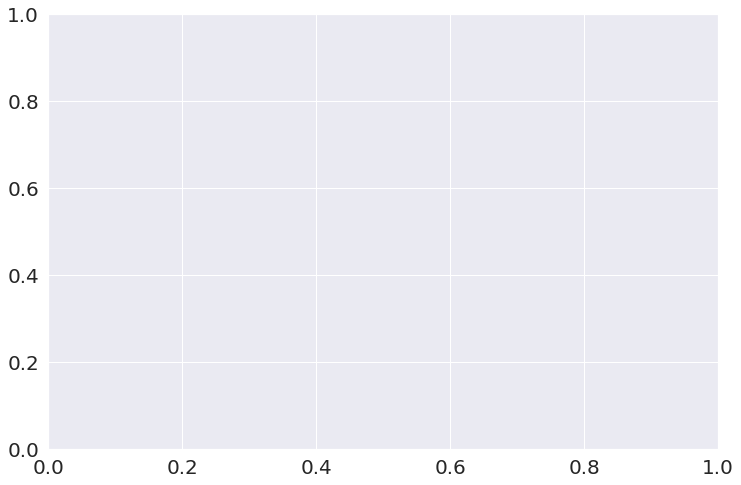

In [87]:
sns.set()
fig, (ax1) = plt.subplots(1,1,figsize = (12,8))

valid_episodes = df[df['Episodes'].notna()]['Episodes']

ax1.tick_params(labelsize=20)
n, bins, patches = ax1.hist(valid_episodes,range=(0,150),bins=150)

ax1.set_title('Episodes',size=22)

print(len(df))

In [ ]:
mpl.rcParams['font.size'] = 20.0
labelfontsize = 14
textprops={'fontsize': 14}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12,12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.1)

top100_mask = df['Rank'] < 101

# Episodes pie

labels = ['1-10', '11-15', '16-20','21-25','25-30','31-40','41-60','61+']

# Source pie
n = 4

g = df[df['Rank'] < 51]['Source']
g = g.groupby(g).size().sort_values(ascending=False)
total = g.sum()

labels = [*g.index.values[:n], 'Other']
sizes = [*g[:n], total-g[:n].sum()]

patches, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90,textprops=textprops)
ax1.axis('equal')
[text.set_fontsize(labelfontsize) for text in texts]

# Genre pie
total = len(df)
n = 12

g = df['Genres']
g = g.str.split(', ')
g = g.explode()
g = g.groupby(g).size().sort_values(ascending=False)
total = g.sum()

labels = [*g.index.values[:n], 'Other']
sizes = [*g[:n], total-g[:n].sum()]

patches, texts, autotexts = ax4.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90,textprops=textprops)
ax4.axis('equal')
[text.set_fontsize(labelfontsize) for text in texts]

# Other genres pie
n = 12

g = df['Genres']
g = g.str.split(', ')
g = g.explode()
g = g.groupby(g).size().sort_values(ascending=False)
total = g.sum()

labels = [*g.index.values[n:]]
sizes = [*g[n:]]

patches, texts, autotexts = ax2.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90,textprops=textprops)
ax2.axis('equal')
[text.set_fontsize(labelfontsize) for text in texts]

"""
# Top 100 genre pie
n = 12

g = df[top100_mask]['Genres']
g = g.str.split(', ')
g = g.explode()
g = g.groupby(g).size().sort_values(ascending=False)
total = g.sum()

labels = [*g.index.values[:n], 'Other']
sizes = [*g[:n], total-g[:n].sum()]

patches, texts, autotexts = ax3.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90,textprops=textprops)
ax3.axis('equal')
[text.set_fontsize(labelfontsize) for text in texts]

# Top 100 other genres pie
n = 12

g = df[top100_mask]['Genres']
g = g.str.split(', ')
g = g.explode()
g = g.groupby(g).size().sort_values(ascending=False)
total = g.sum()

labels = [*g.index.values[n:]]
sizes = [*g[n:]]

patches, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90,textprops=textprops)
ax1.axis('equal')
[text.set_fontsize(labelfontsize) for text in texts]
"""

In [ ]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()


a = 'Fate/Apocrypha'
b = 'Fate/Zero'
similar(a,b)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display



df['Episodes'].replace('',0,inplace=True)
df['Episodes'].replace(np.nan,0,inplace=True)
df=df.astype({'Episodes':'int'})

viewdf = df.dropna()

unique_studios = viewdf.groupby('Studio')['Studio'].size().index.values.tolist()
unique_source = viewdf.groupby('Source')['Source'].size().index.values.tolist()

    
def filt(Episodes, Studio, Source, Sort, Ascending):
        
    a=viewdf[viewdf['Episodes'].notna()]
    a=a[(a['Episodes'] < Episodes[1]) & (a['Episodes'] > Episodes[0])]
    print(Episodes)
    
    if Studio != '':
        a=a[a['Studio'] == Studio]
        
    if Source != '':
        a=a[a['Source'] == Source]
        
    if Sort != '':
        if Sort in ['Rank','Episodes']:
            a=a.sort_values(by=[Sort],ascending=Ascending)
        elif Sort == 'Esoteric':
            a=a.sort_values(by=['Esoteric Rank'],ascending=Ascending)
        elif Sort == 'Title':
            a=a.sort_index(ascending=Ascending)
    
    return a

# Widgets
episodes_w = widgets.IntRangeSlider(min=2, max=100, step=1,value=[2,35])
studio_w = widgets.Combobox(options=unique_studios)
source_w = widgets.Combobox(options=unique_source)
sort_w = widgets.Combobox(options=['Rank','Esoteric','Episodes','Title'])
check_w = widgets.Checkbox()

interact_manual(filt, Episodes=episodes_w, Studio=studio_w, Source=source_w, Sort = sort_w, Ascending=check_w)

In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')